In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

For ConvTranspose2d, refer https://blog.csdn.net/qq_27261889/article/details/86304061

In [2]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False), #output:(N, 512, 4, 4)
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False), #output:(N, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False), #output:(N, 128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False), #output:(N, 64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False), #output:(N, 1, 64, 64)
            nn.Tanh()
        )

    def forward(self, z):
        #z shape:(N, latent_dim, 1, 1)
        return self.model(z)

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False), #output: (N, 64, 32, 32)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False), #output: (N, 128, 16, 16)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False), #output: (N, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False), #output: (N, 512, 4, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False), #output: (N, 1, 1, 1)
            nn.Sigmoid()
        )

    def forward(self, img):
        #img shape:(N, 1, 64, 64)
        return self.model(img).squeeze()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256
lr = 0.0002
latent_dim = 100
img_size = 64
n_epochs = 301
G_losses = []
D_losses = []
test_z = torch.randn(15, latent_dim, 1, 1).to(device)

In [5]:
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
generator.apply(weight_init)
discriminator.apply(weight_init)

criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
dataset = datasets.MNIST(root='../../datasets', train=True, download=True, transform=transform)
x = torch.stack([img for img, _ in dataset]).to(device)
y = torch.stack([torch.tensor(label) for _, label in dataset]).to(device)
dataset_gpu = TensorDataset(x, y)
dataloader = DataLoader(dataset_gpu, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



 51%|█████     | 5.05M/9.91M [00:19<00:18, 257kB/s] 


KeyboardInterrupt: 

[Epoch 0/1001] D Loss: 0.9182 G Loss: 10.2897


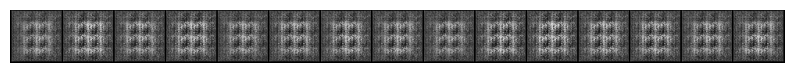

[Epoch 100/1001] D Loss: 0.3914 G Loss: 3.6151


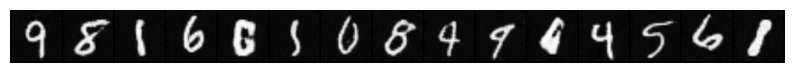

[Epoch 200/1001] D Loss: 0.3735 G Loss: 4.1797


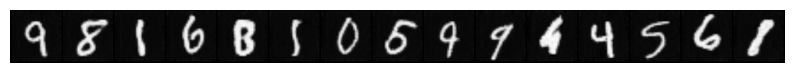

[Epoch 300/1001] D Loss: 0.8195 G Loss: 3.5253


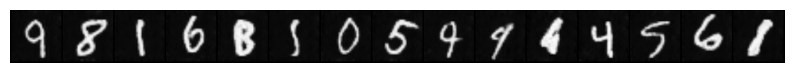

[Epoch 400/1001] D Loss: 0.5633 G Loss: 3.8616


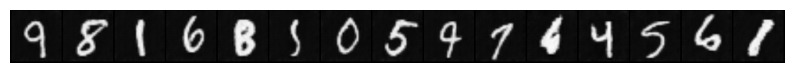

[Epoch 500/1001] D Loss: 0.6934 G Loss: 3.6887


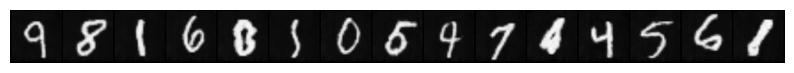

KeyboardInterrupt: 

In [ ]:
for epoch in range(n_epochs):
    generator.train()
    discriminator.train()
    epoch_g_loss = 0
    epoch_d_loss = 0
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        batch_size_curr = real_imgs.size(0)
        real_labels = torch.ones(batch_size_curr).to(device)
        fake_labels = torch.zeros(batch_size_curr).to(device)

        #Train discriminator
        real_output = discriminator(real_imgs)
        d_loss_real = criterion(real_output, real_labels * 0.9) #label smoothing

        z = torch.randn(batch_size_curr, latent_dim, 1, 1).to(device)
        fake_imgs = generator(z)
        fake_output = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        #Train generator
        fake_output = discriminator(fake_imgs)
        g_loss = criterion(fake_output, real_labels)
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        epoch_g_loss += g_loss.detach().cpu().item() * batch_size_curr
        epoch_d_loss += d_loss.detach().cpu().item() * batch_size_curr

    G_losses.append(epoch_g_loss / len(dataset))
    D_losses.append(epoch_d_loss / len(dataset))
    if epoch % 100 == 0:
        print(f"[Epoch {epoch}/{n_epochs}] D Loss: {(epoch_d_loss / len(dataset)):.4f} G Loss: {(epoch_g_loss / len(dataset)):.4f}")
        
        generator.eval()
        with torch.no_grad():
            generated = generator(test_z).detach().cpu()
            grid = make_grid(generated, nrow=15, normalize=True)
            plt.figure(figsize=(10, 10))
            plt.imshow(grid.permute(1, 2, 0))
            plt.axis('off')
            plt.show()